In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
import umap

from matplotlib import pyplot as plt
from IPython.display import clear_output
from typing import Dict, Iterable, Callable
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
print(torch.__version__)


2.1.2+cpu


In [3]:
train_mnist_data = MNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)


test_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:10<00:00, 969282.97it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 242057.89it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 850603.83it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 454265.42it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data, batch_size=32, shuffle=False, num_workers=2
)

Text(0.5, 1.0, 'Image label: 8')

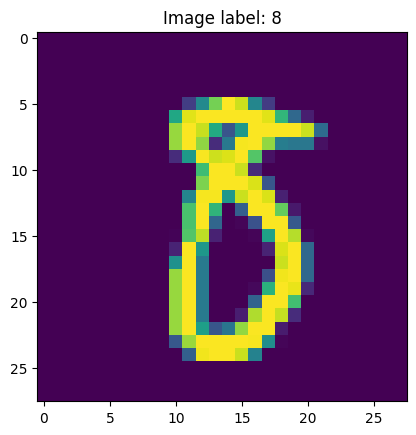

In [5]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

In [6]:
activation = nn.Mish


#Encoder
model = nn.Sequential()
model.add_module('l1_e', nn.Conv2d(1, 4, kernel_size=3, padding=(1, 1), stride=(2, 2)))
model.add_module('activation1', activation())
model.add_module('l2_e', nn.Conv2d(4, 16, kernel_size=3, padding=(1, 1), stride=(2, 2)))
model.add_module('activation2', activation())
model.add_module('l3_e', nn.Conv2d(16, 64, kernel_size=3, padding=(0, 0), stride=(1, 1)))
model.add_module('activation3', activation())
model.add_module('l4_e', nn.Conv2d(64, 256, kernel_size=3, padding=(0, 0), stride=(1, 1)))
model.add_module('activation4', activation())
model.add_module('l5_e', nn.Conv2d(256, 1024, kernel_size=3, padding=(0, 0), stride=(1, 1)))
model.add_module('activation5', activation())


model.add_module('l6_d', nn.ConvTranspose2d(1024, 256, kernel_size=3))
model.add_module('activation6', activation())
model.add_module('l7_d', nn.ConvTranspose2d(256, 64, kernel_size=3))
model.add_module('activation7', activation())
model.add_module('l8_d', nn.ConvTranspose2d(64, 16, kernel_size=3))
model.add_module('activation8', activation())
model.add_module('l9_e', nn.ConvTranspose2d(16, 4, kernel_size=4, padding=(1, 1), stride=(2, 2), dilation=(1, 1)))
model.add_module('activation9', activation())
model.add_module('l10_e', nn.ConvTranspose2d(4, 1, kernel_size=4, padding=(1, 1), stride=(2, 2), dilation=(1, 1)))


# model.add_module('l3', nn.Conv2d(15, 50, kernel_size=3, padding=(1, 1)))

In [7]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 3
loss_func = nn.MSELoss(reduction='mean')

In [8]:
def train_model(model, train_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    input_im = []
    output_im = []
    
    for epoch in tqdm(range(n_epochs)):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        i = 0
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # move data to target device
            ### YOUR CODE HERE

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            ### YOUR CODE HERE
            # print(X_batch.reshape(-1, 1, 28, 28).shape)
            y_pred = model(X_batch.reshape(-1, 1, 28, 28))
            # print(y_pred.shape)
            # print(y_pred.shape)
            loss = loss_func(y_pred, X_batch.reshape(-1, 1, 28, 28))
            loss.backward()
            opt.step()
            opt.zero_grad()
            ep_train_loss.append(loss.item())

            if ((epoch == 0) and (i == 0)):
                input_im.append(X_batch.reshape(-1, 1, 28, 28))
                output_im.append(y_pred)

            i += 1
                
        model.train(False) # disable dropout / use averages for batch_norm
            


        train_loss.append(np.mean(ep_train_loss))
        # print(train_loss)
        # val_loss.append(np.mean(ep_val_loss))
        # val_accuracy.append(np.mean(ep_val_accuracy))

    return model, train_loss, input_im, output_im

In [11]:
if False:
    model, train_loss, input_im, output_im = train_model(model, train_data_loader, loss_func, opt, n_epochs)
    torch.save(model.state_dict(), 'model_weights_cnn.pth')

if False:
    model.load_state_dict(torch.load('model_weights_cnn.pth'))

In [12]:
if False:
    class VerboseExecution(nn.Module):
        def __init__(self, model: nn.Module):
            super().__init__()
            self.model = model
    
            # Register a hook for each layer
            for name, layer in self.model.named_children():
                layer.__name__ = name
                layer.register_forward_hook(
                    lambda layer, _, output: print(f"{layer.__name__}: {output.shape}")
                )

        def forward(self, x):
            return self.model(x)

    
    verbose_resnet = VerboseExecution(model)
    print(verbose_resnet(_image))

NameError: name 'train_loss' is not defined

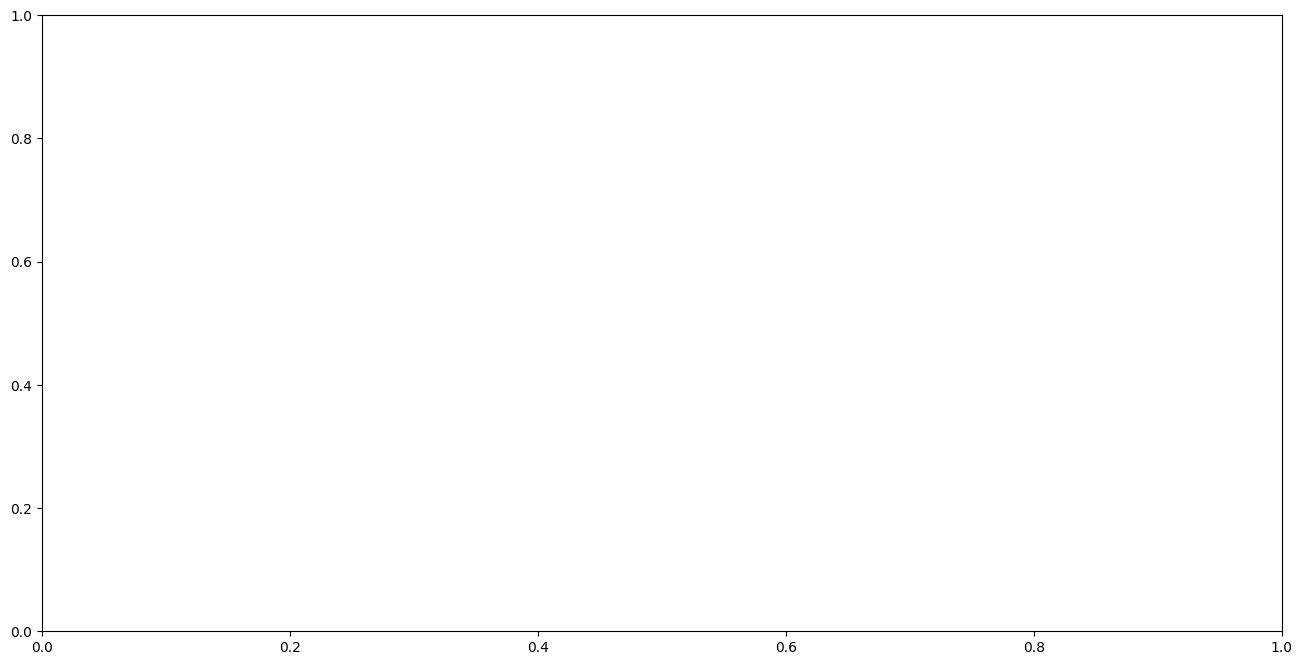

In [13]:
fig, ax = plt.subplots(1, figsize=(16, 8))
ax.plot(train_loss)
ax.set_title("MSE")

In [14]:
print(len(input_im))
print(len(output_im))
print(input_im[0].shape)

for i in range(10):
    im_x = input_im[0][i].detach().numpy()
    im_y = output_im[0][i].detach().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(im_x.reshape(28, 28))
    
    ax[1].imshow(im_y.reshape(28, 28))

NameError: name 'input_im' is not defined

In [15]:
for i in range(10):
    y_pred = model(input_im[0][i])

    im_x = input_im[0][i].detach().numpy()
    im_y = y_pred.detach().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(im_x.reshape(28, 28))
    
    ax[1].imshow(im_y.reshape(28, 28))

NameError: name 'input_im' is not defined

In [16]:
if False:
    class FeatureExtractor(nn.Module):
        def __init__(self, model: nn.Module, layers: Iterable[str]):
            super().__init__()
            self.model = model
            self.layers = layers
            self._features = {layer: torch.empty(0) for layer in layers}
    
            for layer_id in layers:
                layer = dict([*self.model.named_modules()])[layer_id]
                layer.register_forward_hook(self.save_outputs_hook(layer_id))
    
        
        def save_outputs_hook(self, layer_id: str) -> Callable:
            def fn(_, __, output):
                self._features[layer_id] = output
            return fn
    
        
        def forward(self, x):
            _ = self.model(x)
            return self._features


    resnet_features = FeatureExtractor(model, layers=["l5_e"])
    features = resnet_features(_image)

    print('\n', (features["l5_e"].detach().numpy()))

In [17]:
# features_data = features["l5_e"].detach().numpy()

# # print(features_data)
# # print(features_data[0][0][0])

# features_data_norm = np.array([])
# for i in features_data:
#     features_data_norm = np.append(features_data_norm, float(i[0][0]))


# names = 
# df_1 = pd.DataFrame(features_data_norm)

# df_1.to_csv('out2.csv', index=False) 

# print(features_data_norm)

In [18]:
# d = {a: [float(features_data_norm[a]), float(features_data_norm[a])]  for a in range(1024)}
# # print(d)
# df_1 = pd.DataFrame.from_dict(d)
# df_1.insert(0, "Target", [2, 2], True)
# df_1.loc[len(df_1)] = np.append([2], features_data_norm)

# df_1.to_csv('out2.csv', index=False)

In [19]:
# new_row = {'Name': 'Eve', 'Age': 28, 'City': 'Boston'}
# df = pd.DataFrame({'data': [features_data_norm],

#                    'target': [2]})

# df.to_csv('out.csv', index=False) 

# df = pd.concat([df, pd.DataFrame({'data': [features_data_norm], 'target': 2})], ignore_index=True)

# df.to_csv('out1.csv', index=False) 

## Модуль отвечает за вывод данных модели

In [20]:
if False:
    d = {a: [float(features_data_norm[a])]  for a in range(1024)}
    # print(d)
    df = pd.DataFrame.from_dict(d)
    print(df)
    df.insert(0, "Target", [2], True)
    
    eval_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
    )

    eval_data_loader = torch.utils.data.DataLoader(
    eval_mnist_data, batch_size=1, shuffle=False, num_workers=2
    )

    data = []
    model.eval()
    with torch.no_grad():
        for batch, y_batch in tqdm(eval_data_loader):
            resnet_features = FeatureExtractor(model, layers=["l5_e"])
            features = resnet_features(batch[0])

            features_data = features["l5_e"].detach().numpy()
            features_data_norm = []
            for i in features_data:
                features_data_norm.append(float(i[0][0]))
            
            # df = pd.concat([df, pd.DataFrame({'data': [features_data_norm], 'target': y_batch})], ignore_index=True)
            df.loc[len(df)] = np.append([y_batch], features_data_norm)
            
            # data.append(features["l5_e"].detach().numpy())
    df.to_csv('out.csv', index=False) 

## Модуль отвечает за вывод данных без модели

In [39]:
if True:
    d = {a: [0] for a in range(784)}
    # print(d)
    df = pd.DataFrame.from_dict(d)
    print(df)
    df.insert(0, "Target", [2], True)
    
    eval_mnist_data = MNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
    )

    eval_data_loader = torch.utils.data.DataLoader(
    eval_mnist_data, batch_size=1, shuffle=False, num_workers=2
    )

    data = []

    if True:
        for batch, y_batch in tqdm(eval_data_loader):
            # print(np.size(batch.detach().numpy()))

            # features_data = features["l5_e"].detach().numpy()
            # features_data_norm = []
            # for i in features_data:
            #     features_data_norm.append(float(i[0][0]))
            

            df.loc[len(df)] = np.append([y_batch], batch.detach().numpy())
            # print(batch)
            
            # data.append(features["l5_e"].detach().numpy())
    df.to_csv('out.csv', index=False) 

   0    1    2    3    4    5    6    7    8    9    ...  774  775  776  777  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   778  779  780  781  782  783  
0    0    0    0    0    0    0  

[1 rows x 784 columns]


  0%|          | 0/10000 [00:00<?, ?it/s]

In [40]:
print(df.shape[0])

10001


In [41]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(df.drop('Target', axis=1)) # преобразовываем

In [42]:
print(embedding.shape)

(10001, 2)


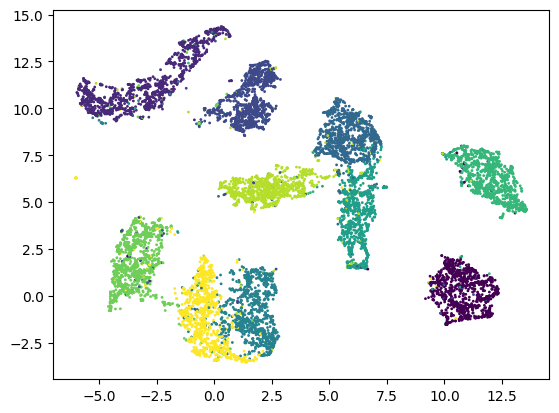

In [43]:
plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, c=df['Target'])

In [16]:
if False:
    data_list = []
    
    for i in data:
        list_num = []
        for j in i[0]:   
            list_num.append(float(j[0][0]))
        data_list.append(list_num)
    
    print(data_list)

In [17]:
if False:
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in train_data_loader:
            y_predicted = model(batch[0].reshape(-1, 1, 28, 28))
            predicted_labels.append(y_predicted)
            # real_labels.append(batch[1])
    
    predicted_labels = torch.cat(predicted_labels)
# real_labels = torch.cat(real_labels)
# train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()